In [ ]:
# test hypothesis whether shape (directionality) of CCG within +/-13 ms could be a sole consequence of dynamics
# negative control method:
# 1. get early and late PSTH
# 2. simulate spike train with trials from a PSTH (use method similar to jitter method)
# 3. calculate jitter correctetd ccg between the two simulatred 


In [7]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import scipy
from scipy.ndimage import gaussian_filter


def xcorrfft(a,b,NFFT):
    # first dimention of a should be length of time
    CCG = np.fft.fftshift(np.fft.ifft(np.multiply(np.fft.fft(a,NFFT), np.conj(np.fft.fft(b,NFFT)))))
    return CCG

def nextpow2(n):
    """get the next power of 2 that's greater than n"""
    m_f = np.log2(n)
    m_i = np.ceil(m_f)
    return 2**m_i


def jitter(data, l):
    # matlab reshape default is Fortran order, but python default is 'C' order, when converting code, need to specify order
    """Jitter correction adapted from Amin. Used in several neuron papers.
       Jittering multidemntational logical data where 
       0 means no spikes in that time bin and 1 indicates 
       a spike in that time bin.
       First dimention should be time and second should be the trial number.
       data: time*trial*ori
       l: time window
    """
    if len(np.shape(data))>3:
        flag = 1
        sd = np.shape(data)
        data = np.reshape(data,(np.shape(data)[0],np.shape(data)[1],len(data.flatten())/(np.shape(data)[0]*np.shape(data)[1])), order='F')
    else:
        flag = 0

    psth = np.mean(data,axis=1)
    length = np.shape(data)[0]

    if np.mod(np.shape(data)[0],l):
        data[length:(length+np.mod(-np.shape(data)[0],l)),:,:] = 0
        psth[length:(length+np.mod(-np.shape(data)[0],l)),:]   = 0

    if np.shape(psth)[1]>1:
        dataj = np.squeeze(np.sum(np.reshape(data,[l,np.shape(data)[0]//l,np.shape(data)[1],np.shape(data)[2]], order='F'), axis=0))
        psthj = np.squeeze(np.sum(np.reshape(psth,[l,np.shape(psth)[0]//l,np.shape(psth)[1]], order='F'), axis=0))
    else:
        dataj = np.squeeze(np.sum(np.reshape(data,l,np.shape(data)[0]//l,np.shape(data)[1], order='F')))
        psthj = np.sum(np.reshape(psth,l,np.shape(psth)[0]//l, order='F'))


    if np.shape(data)[0] == l:
        dataj = np.reshape(dataj,[1,np.shape(dataj)[0],np.shape(dataj)[1]], order='F');
        psthj = np.reshape(psthj,[1,np.shape(psthj[0])], order='F');

    psthj = np.reshape(psthj,[np.shape(psthj)[0],1,np.shape(psthj)[1]], order='F')
    psthj[psthj==0] = 10e-10

    corr = dataj/np.tile(psthj,[1, np.shape(dataj)[1], 1]);
    corr = np.reshape(corr,[1,np.shape(corr)[0],np.shape(corr)[1],np.shape(corr)[2]], order='F')
    corr = np.tile(corr,[l, 1, 1, 1])
    corr = np.reshape(corr,[np.shape(corr)[0]*np.shape(corr)[1],np.shape(corr)[2],np.shape(corr)[3]], order='F');

    psth = np.reshape(psth,[np.shape(psth)[0],1,np.shape(psth)[1]], order='F');
    output = np.tile(psth,[1, np.shape(corr)[1], 1])*corr

    output = output[:length,:,:]
    return output

def jitter_1d(data, l):
    # matlab reshape default is Fortran order, but python default is 'C' order, when converting code, need to specify order
    """
       Jitter correction adapted from Amin. Used in several neuron papers.
       Jitter method keeps PSTH shape but shuffle spike times within jitter window.
       Used 'shuffle jitter' metthod to permute trial label of single spikes within jitter window.
       This method detect fast non-event locked correlation.
       
       Jittering multidemntational logical data where 
       0 means no spikes in that time bin and 1 indicates 
       a spike in that time bin.
       First dimention should be time and second should be the trial number.
       data: time*trial
       l: time window
    """

    psth = np.mean(data,axis=1)
    length = np.shape(data)[0]

    if np.mod(np.shape(data)[0],l):
        data[length:(length+np.mod(-np.shape(data)[0],l)),:,:] = 0
        psth[length:(length+np.mod(-np.shape(data)[0],l)),:]   = 0

    if len(np.shape(psth))>1:
        dataj = np.squeeze(np.sum(np.reshape(data,[l,np.shape(data)[0]//l,np.shape(data)[1],np.shape(data)[2]], order='F'), axis=0))
        psthj = np.squeeze(np.sum(np.reshape(psth,[l,np.shape(psth)[0]//l,np.shape(psth)[1]], order='F'), axis=0))
        psthj = np.reshape(psthj,[np.shape(psthj)[0],1,np.shape(psthj)[1]], order='F')
        
        psthj[psthj==0] = 10e-10
        corr = dataj/np.tile(psthj,[1, np.shape(dataj)[1], 1]);
        corr = np.reshape(corr,[1,np.shape(corr)[0],np.shape(corr)[1],np.shape(corr)[2]], order='F')
        corr = np.tile(corr,[l, 1, 1, 1])
        corr = np.reshape(corr,[np.shape(corr)[0]*np.shape(corr)[1],np.shape(corr)[2],np.shape(corr)[3]], order='F');
        psth = np.reshape(psth,[np.shape(psth)[0],1,np.shape(psth)[1]], order='F');
        output = np.tile(psth,[1, np.shape(corr)[1], 1])*corr
        output = output[:length,:,:]
        
    elif len(np.shape(psth))==1:
        dataj = np.squeeze(np.sum(np.reshape(data,[l,np.shape(data)[0]//l,np.shape(data)[1]], order='F'), axis=0))
        psthj = np.sum(np.reshape(psth,[l,np.shape(psth)[0]//l], order='F'), axis=0)
        psthj = np.reshape(psthj,[np.shape(psthj)[0],1], order='F')
        
        psthj[psthj==0] = 10e-10
        corr = dataj/np.tile(psthj,[1, np.shape(dataj)[1]])
        corr = np.reshape(corr,[1,np.shape(corr)[0],np.shape(corr)[1]], order='F')
        corr = np.tile(corr,[l, 1, 1])
        corr = np.reshape(corr,[np.shape(corr)[0]*np.shape(corr)[1],np.shape(corr)[2]], order='F');
        psth = np.reshape(psth,[np.shape(psth)[0],1], order='F');
        output = np.tile(psth,[1, np.shape(corr)[1]])*corr
        output = output[:length,:]
        
    if np.shape(data)[0] == l:
        dataj = np.reshape(dataj,[1,np.shape(dataj)[0],np.shape(dataj)[1]], order='F');
        psthj = np.reshape(psthj,[1,np.shape(psthj[0])], order='F');
        
    return output

In [3]:
import random
def possion_times(spike_times):
    # given an input spike train, make the times a rate-matched Poisson process
    # FR= spk/sec
    rate = sum(spike_times) / float(len(spike_times))
    #print(len(np.array(spike_times)))
    if rate>0:
        #print(rate)
        # keep time to first spike
        t = 0
        poiss = [t]
        for i in range(len(np.where(spike_times==1)[0])-1):
            t+=int(round(random.expovariate(rate)))
            if t<len(spike_times):
                poiss.append(t)
            
    else:
        poiss=spike_times
    new_spikes=np.zeros(len(spike_times))
    new_spikes[poiss[1:]]=1
    return new_spikes

In [4]:
import random
def possion_times_rate(rate, t_len):
    """
    # given rate and time length, simulate possion spike train
    # rate= spk/ms
    """
    t = 0
    poiss = [t]
    for i in range(t_len-1):
        t+=int(round(random.expovariate(rate)))
        if t<t_len:
            poiss.append(t)
    new_spikes=np.zeros(t_len)
    new_spikes[poiss[1:]]=1
    return new_spikes

# load data for PSTH template

In [5]:
#tmp = np.load('/Volumes/local1/work_allen/Ephys/mouse408153/psth_pref.npy')
#data = tmp[0]
#time = tmp[1]

tmp = np.load('/Users/xiaoxuanj/work/work_allen/Ephys/mouse408153/psth_pref_trial.npy')
data = tmp

df = pd.read_csv('/Users/xiaoxuanj/work/work_allen/Ephys/mouse408153/matrix/mouse408153_cortex_meta.csv')
data = data[df.FR>2,:,:]
df = df[df.FR>2]

assert data.shape[0]==len(df)

cluster = np.load('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/functional_cluster/mouse408153_CCG_diff_cluster_labels.npy')
assert len(df)==len(cluster)

In [6]:
data.shape

(375, 75, 2510)

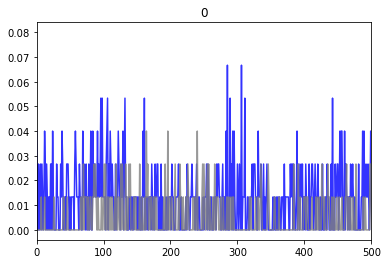

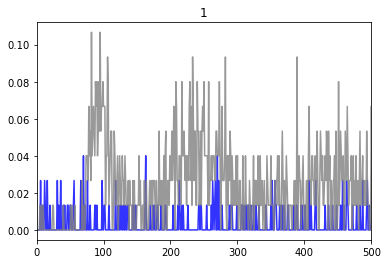

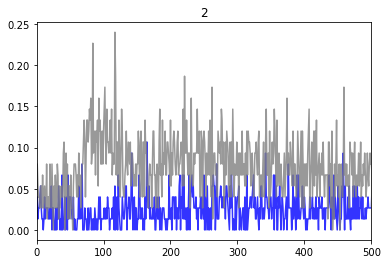

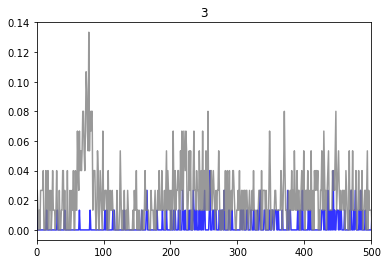

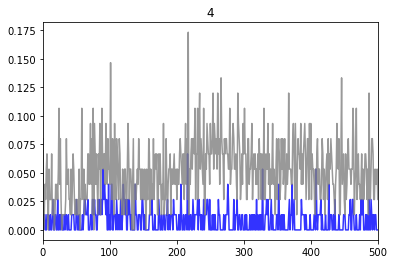

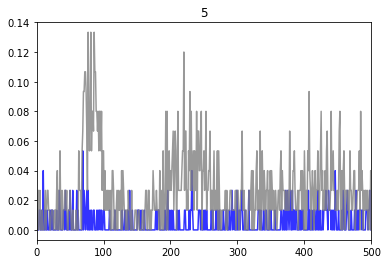

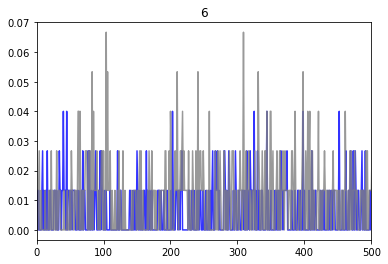

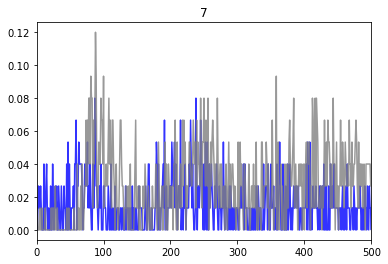

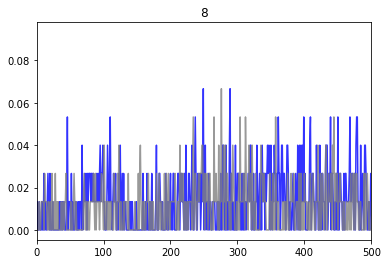

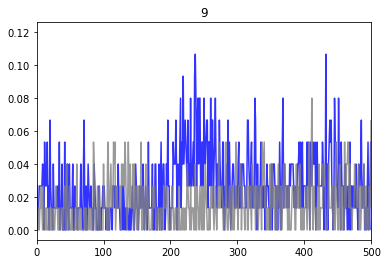

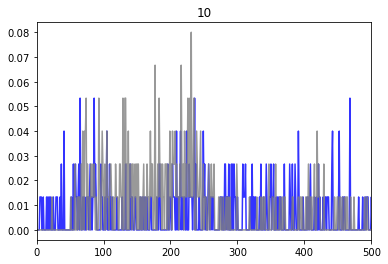

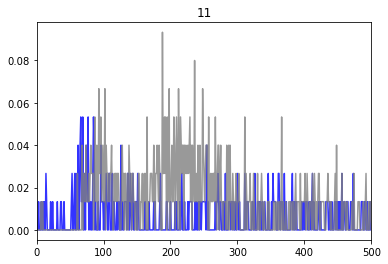

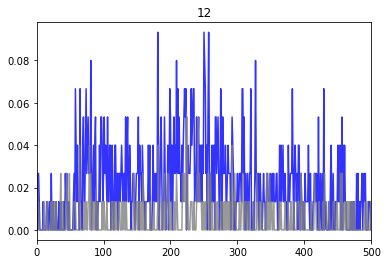

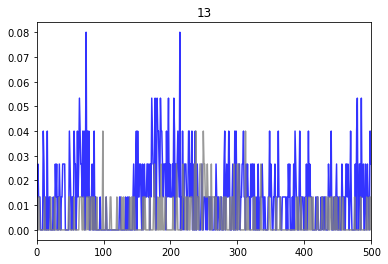

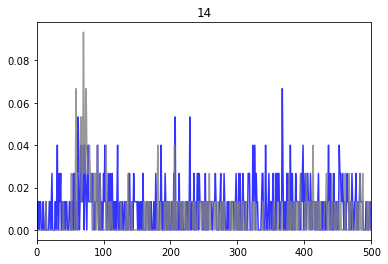

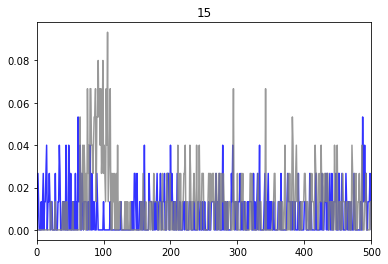

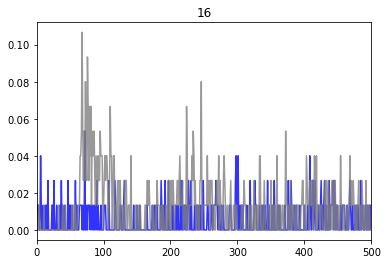

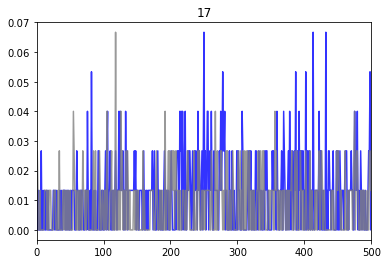

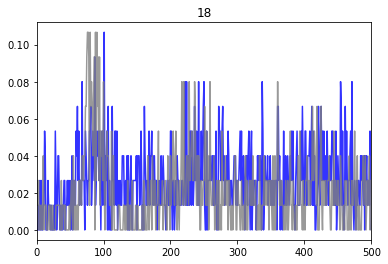

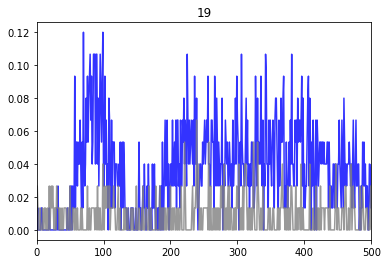

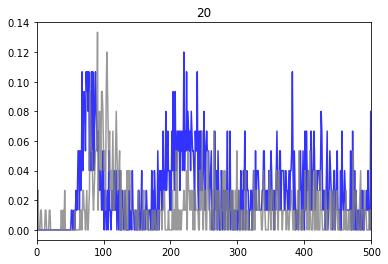

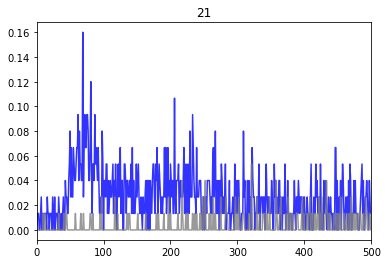

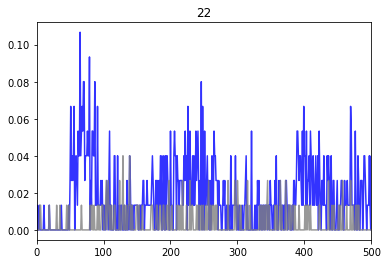

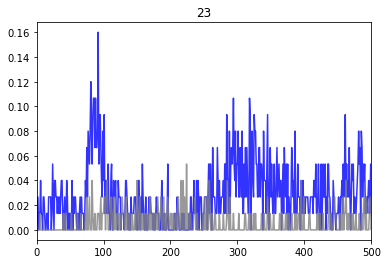

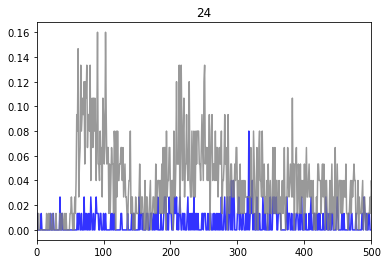

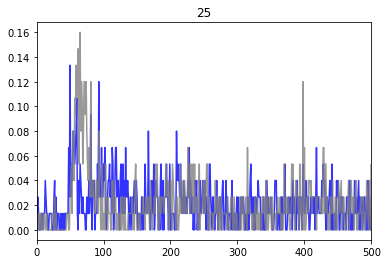

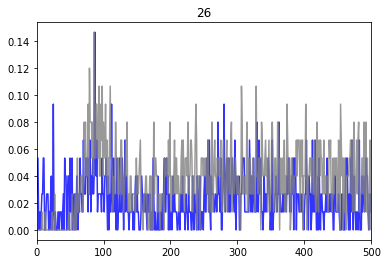

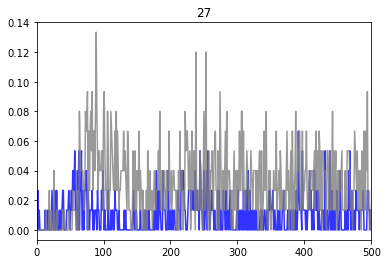

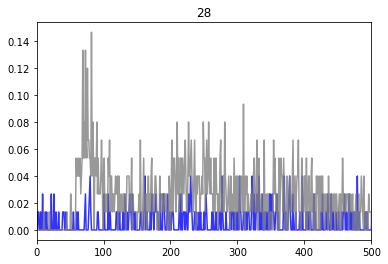

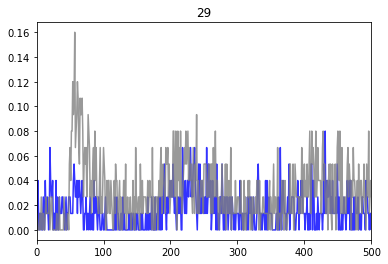

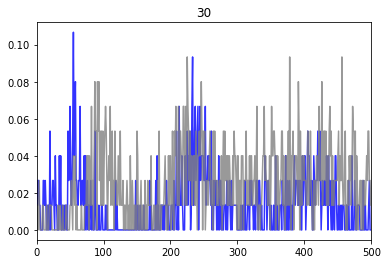

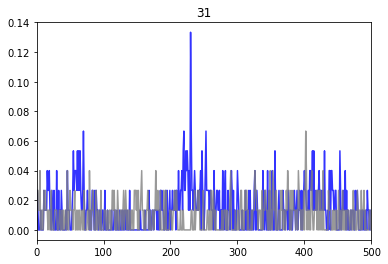

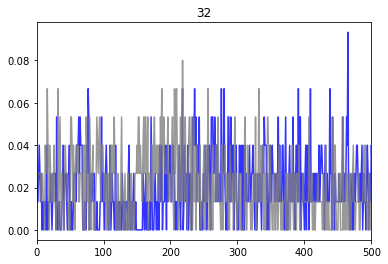

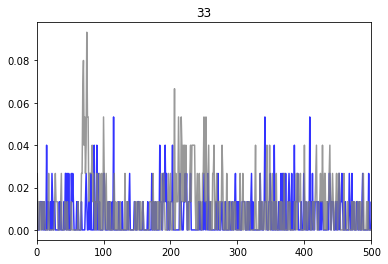

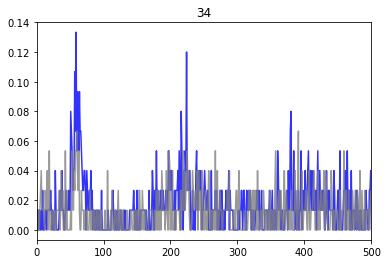

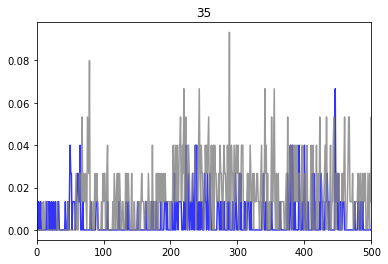

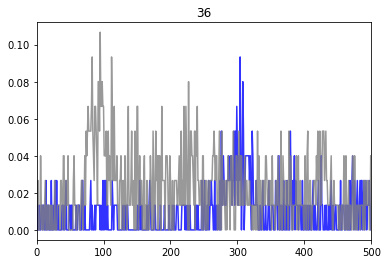

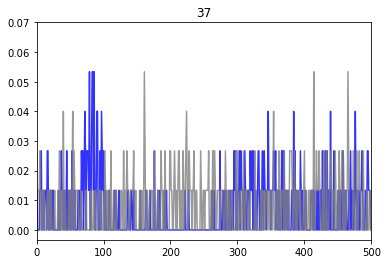

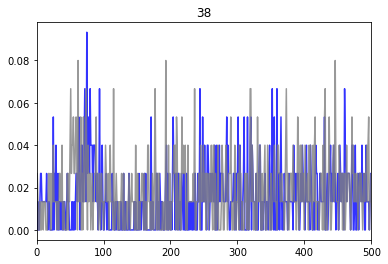

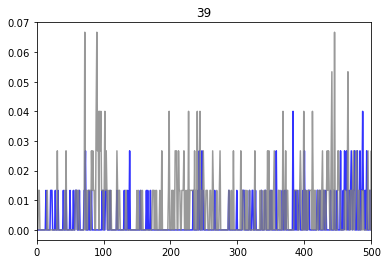

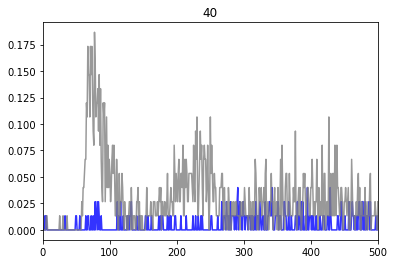

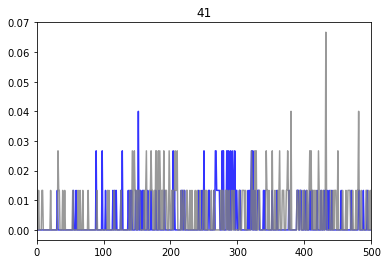

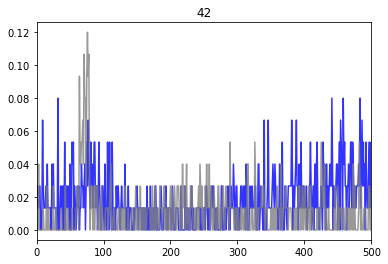

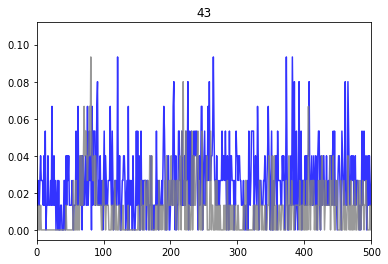

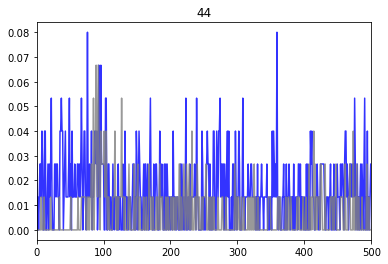

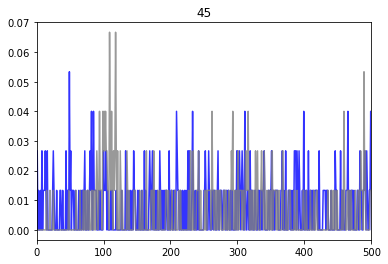

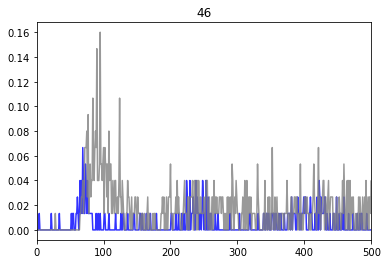

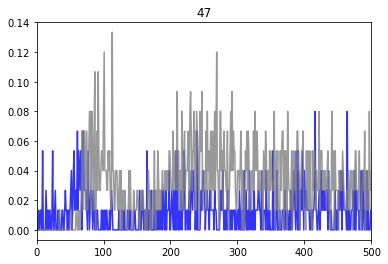

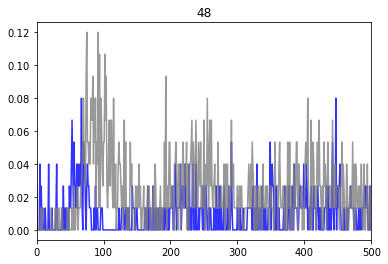

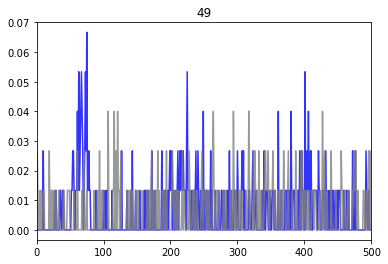

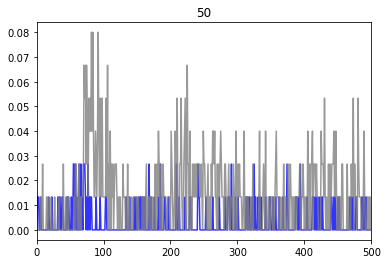

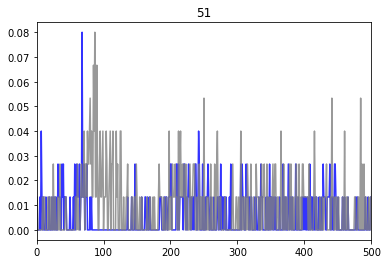

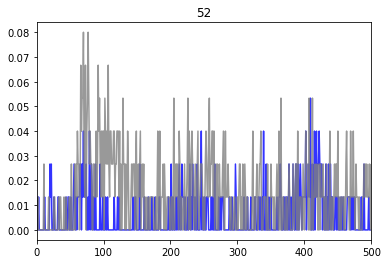

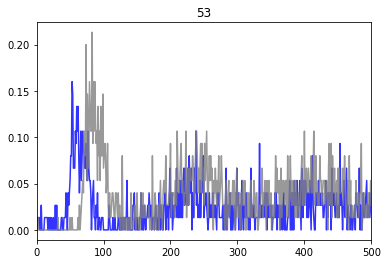

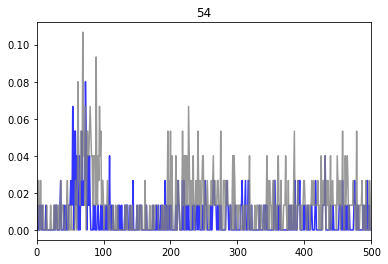

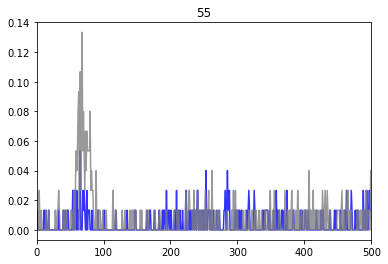

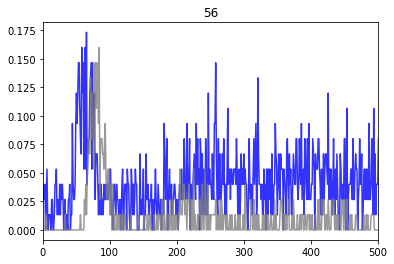

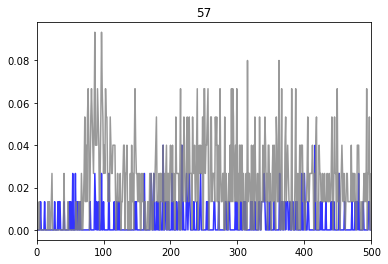

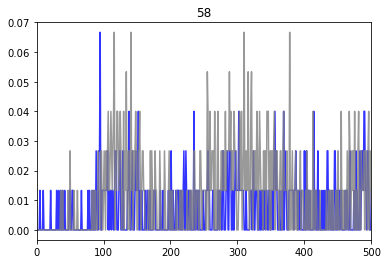

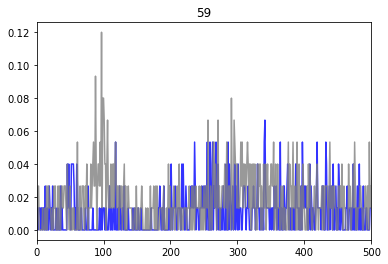

In [7]:
for idx in range(60):
    plt.figure()
    plt.plot(data[np.where(cluster==2)[0][idx],:,:].mean(0)[:2000], c='blue', alpha=0.8)
    plt.plot( data[np.where(cluster==3)[0][idx],:,:].mean(0)[:2000], c='gray', alpha=0.8)
    plt.xlim([0,500])
    plt.title(idx)
#plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/dynamics_example.pdf')

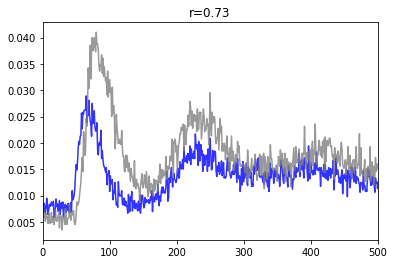

In [12]:
plt.plot(data[np.where(cluster==2)[0],:,:].mean(1).mean(0)[:2000], c='blue', alpha=0.8)
plt.plot( data[np.where(cluster==3)[0],:,:].mean(1).mean(0)[:2000], c='gray', alpha=0.8)
plt.xlim([0,500])
plt.title('r=0.73')
plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/dynamics_example.pdf')

Text(0.5, 1.0, 'Real data; r=0.34')

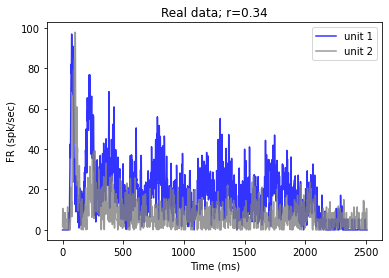

In [8]:
idx=20
plt.plot(gaussian_filter(data[np.where(cluster==2)[0][idx],:,:].mean(0), 1)*1000, c='blue', alpha=0.8, label='unit 1')

#idx=1
plt.plot(gaussian_filter(data[np.where(cluster==3)[0][idx],:,:].mean(0), 1)*1000, c='gray', alpha=0.8, label='unit 2')
#plt.xlim([0,0.5])
plt.legend()
plt.ylabel('FR (spk/sec)')
plt.xlabel('Time (ms)')
plt.title('Real data; r=0.34')
#plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/dynamics_ccg/dynamics_example.pdf')

In [9]:
np.corrcoef(gaussian_filter(data[np.where(cluster==2)[0][idx],:,:].mean(0), 1), gaussian_filter(data[np.where(cluster==3)[0][idx],:,:].mean(0), 1))

array([[1.        , 0.33753198],
       [0.33753198, 1.        ]])

In [19]:
repeat = 100
psth1 = gaussian_filter(data[np.where(cluster==2)[0][idx],:,:].mean(0), 1)+0.001

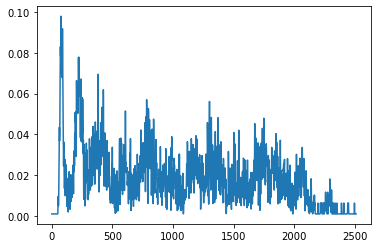

In [20]:
plt.plot(psth1)

In [26]:
# simulate Possion spike train based on PSTH
# For a given mean firing rate at a particular time point, simulate Poisson spikes across repeats
t_len=2000
spcounts1 = np.array([possion_times_rate(psth1[i], 100) for i in range(t_len)])
spcounts2 = np.array([possion_times_rate(psth1[i], 100) for i in range(t_len)])



In [29]:
np.save('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/simulation/spcounts1.npy', spcounts1)
np.save('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/simulation/spcounts2.npy', spcounts2)
np.save('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/simulation/psth.npy', psth1)

In [5]:
spcounts1 = np.load('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/simulation/spcounts1.npy')
spcounts2 = np.load('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/simulation/spcounts2.npy')
psth1 = np.load('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/simulation/psth.npy')

Text(0.5, 0, 'Time (ms)')

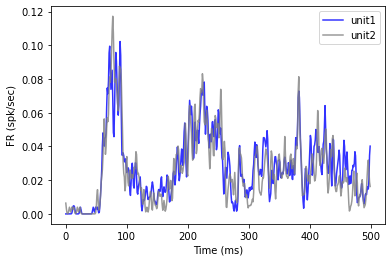

In [32]:
spcounts1 = np.load('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/simulation/spcounts1.npy')
spcounts2 = np.load('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/simulation/spcounts2.npy')

plt.plot(gaussian_filter(spcounts1.T.mean(0), 1)[:500], c='blue', alpha=0.8, label='unit1')
plt.plot(gaussian_filter(spcounts2.T.mean(0), 1)[:500], c='gray', alpha=0.8, label='unit2')
#plt.xlim([0,0.5])
plt.legend()
plt.ylabel('FR (spk/sec)')
plt.xlabel('Time (ms)')

#plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/dynamics_ccg/dynamics_example_simulated_negative_control2_psth_500.pdf')
#plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/dynamics_ccg/dynamics_example_simulated_negative_control2_psth.pdf')

In [33]:
spcounts2 = spcounts2.T
spcounts1 = spcounts1.T

In [34]:
repeat=100
t_len=2000

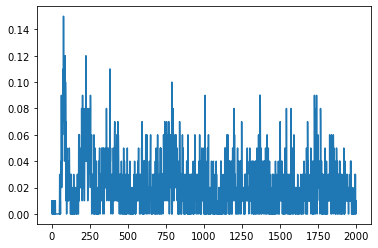

In [35]:
plt.plot(spcounts2.mean(0))

In [17]:
new = np.array([possion_times_rate(0.001, t_len) for i in range(repeat)])
new.shape

(100, 2000)

In [36]:
# generate synchronized spikes
new = np.array([possion_times_rate(0.01, t_len) for i in range(repeat)])

# circshift synchronized spikes to generate correlated spikes with fixed delay
new2 = np.zeros([100,2000])
#new2[:,:1800]=new[:,200:]
#new2[:,1800:]=new[:,:200]

new2[:,:1980]=new[:,20:]
new2[:,1980:]=new[:,:20]


Text(0, 0.5, 'Repeats')

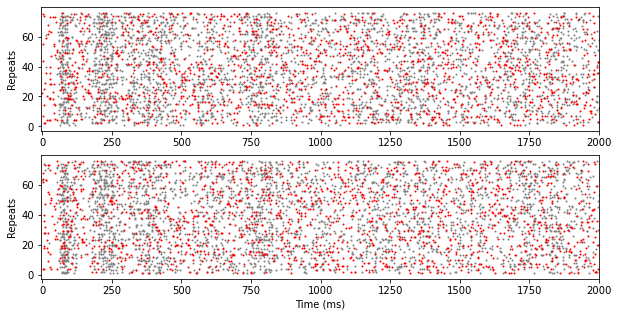

In [37]:
plt.figure(figsize=(10,5))
plt.subplot(211)
for i,temp in enumerate(spcounts1):
    # plot raster for all units in a given time window or trial
    if i<=75:
        x = np.where(temp!=0)[0]
        y = np.ones(len(x))*(i+1)
        plt.plot(x, y, '.', c='gray', markersize=2)
        plt.tick_params(direction='out')
    
for i,temp in enumerate(new):
    # plot raster for all units in a given time window or trial
    if i<=75:
        x = np.where(temp!=0)[0]
        y = np.ones(len(x))*(i+1)
        plt.plot(x, y, '.', c='r', markersize=2)
        plt.tick_params(direction='out')
plt.xlim([-5,2000])
plt.ylabel('Repeats')

plt.subplot(212)
for i,temp in enumerate(spcounts2):
    # plot raster for all units in a given time window or trial
    if i<=75:
        x = np.where(temp!=0)[0]
        y = np.ones(len(x))*(i+1)
        plt.plot(x, y, '.', c='gray', markersize=2)
        plt.tick_params(direction='out')
    
for i,temp in enumerate(new2):
    # plot raster for all units in a given time window or trial
    if i<=75:
        x = np.where(temp!=0)[0]
        y = np.ones(len(x))*(i+1)
        plt.plot(x, y, '.', c='r', markersize=2)
        plt.tick_params(direction='out')
plt.xlim([-5,2000])
plt.xlabel('Time (ms)')
plt.ylabel('Repeats')
#plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/dynamics_ccg/dynamics_example_simulated_negative_control2_afterdelayedsynch_raster_10.pdf')

#plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/dynamics_ccg/dynamics_example_simulated_negative_control2_afterdelayedsynch_raster.pdf')



In [38]:
spcounts1 = spcounts1+new
spcounts2 = spcounts2+new2

spcounts1[spcounts1 > 1] = 1
spcounts2[spcounts2 > 1] = 1

FR1 = np.mean(spcounts1.sum(1)/2.)
FR2 = np.mean(spcounts2.sum(1)/2.)
print(FR1, FR2)



31.31 30.95


In [41]:
# compute CCG

In [39]:
# input shape is time*neuron*ori*rep
jitterwindow=25
n_t = np.shape(spcounts1)[1]
NFFT = int(nextpow2(2*n_t))
t = np.arange(-(n_t-1),(n_t-1))
theta = n_t-np.abs(t)

# jittered PSTH
# Jitter method keeps PSTH shape but shuffle spike times within jitter window.
# Used 'shuffle jitter' metthod to permute trial label of single spikes within jitter window.
# Thus the trial averaged PSTH show the exact same shape as original PSTH
# This method detect fast non-event locked correlation.
ttemp1 = jitter_1d(spcounts1.T,jitterwindow)  
ttemp2 = jitter_1d(spcounts2.T,jitterwindow)
tempjitter = xcorrfft(ttemp1.T, ttemp2.T,NFFT)
        
ccg = xcorrfft(spcounts1,spcounts2,NFFT)


Text(0.5, 0, 'Time (ms)')

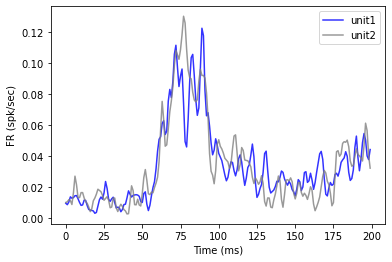

In [42]:
plt.plot(gaussian_filter(spcounts1.mean(0), 1)[:200], c='blue', alpha=0.8, label='unit1')
plt.plot(gaussian_filter(spcounts2.mean(0), 1)[:200], c='gray', alpha=0.8, label='unit2')
#plt.xlim([0,0.5])
plt.legend()
plt.ylabel('FR (spk/sec)')
plt.xlabel('Time (ms)')
#plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/dynamics_ccg/dynamics_example_simulated_negative_control2_afterdelayedsynch_10_all.pdf')
#plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/dynamics_ccg/dynamics_example_simulated_negative_control2_afterdelayedsynch.pdf')

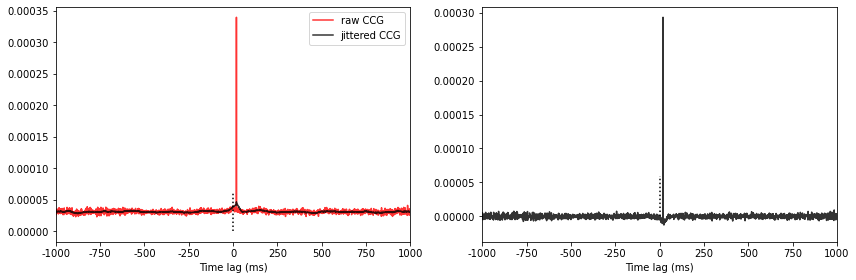

In [43]:
# xcorr capture correlation in the PSTH
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(ccg.mean(0)[int(4096/2)-int(3998/2):int(4096/2)+int(3998/2)]/theta/np.sqrt(FR1*FR2), c='red', alpha=0.8, label='raw CCG')
plt.plot(tempjitter.mean(0)[int(4096/2)-int(3998/2):int(4096/2)+int(3998/2)]/theta/np.sqrt(FR1*FR2), c='k', alpha=0.8, label='jittered CCG')
plt.xlim([int(3998/2)-1000,int(3998/2)+1000])
#plt.ylim([0.001,0.0025])
#plt.ylim([0.225,0.240])
#plt.plot([2000, 2000],[0.0002,0.0012],':k')
plt.xticks(np.arange(1000,3001, 250), np.arange(-1000, 1001, 250))
plt.plot([2001,2001],[0,6e-5],':k')
plt.xlabel('Time lag (ms)')
plt.legend()


# sharp peak exist with synchronized spikes
plt.subplot(122)
plt.plot(((ccg.mean(0)-tempjitter.mean(0))[int(4096/2)-int(3998/2):int(4096/2)+int(3998/2)]/theta/np.sqrt(FR1*FR2)), 'k', alpha=0.8,)
#plt.plot([250,250],[0, 0.002])
plt.xlim([int(3998/2)-1000,int(3998/2)+1000])
#plt.ylim([-0.00002,6e-5])
#plt.plot([2000, 2000],[-0.0002,0.0006],':k')
plt.xticks(np.arange(1000,3001, 250), np.arange(-1000, 1001, 250))
plt.xlabel('Time lag (ms)')
plt.plot([2001,2001],[0,6e-5],':k')
plt.tight_layout()
#plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/dynamics_ccg/negative_control2_delayedsynch_10.pdf')
#plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/dynamics_ccg/negative_control2_delayedsynch.pdf')

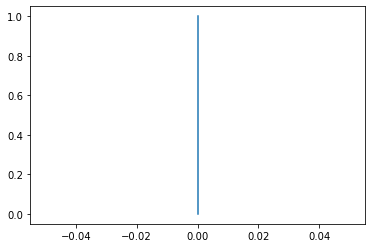

In [51]:
plt.plot([0,0],[0,1])